# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import scipy

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Read updated *Nikos* data

In [2]:
xls = pd.ExcelFile('data/edited_nikos_data.xlsx')
xls.sheet_names

['ANAMET',
 'Anamet data',
 'ISRI',
 'Isri data',
 'UNS data',
 'Elements data',
 'Material data',
 'Process']

In [5]:
uns_data = pd.read_excel(xls, 'UNS data')

uns_data.rename(columns = {'sc:isComposedOf':'elements id'}, inplace = True)

elements_data = pd.read_excel(xls, 'Elements data')

uns_data = pd.merge(uns_data, elements_data, how='inner', on = 'elements id')
isri_data = pd.read_excel(xls, 'Isri data')
anamet_data = pd.read_excel(xls, 'Anamet data')
material_data = pd.read_excel(xls, 'Material data')
elements_data = pd.read_excel(xls, 'Elements data')

In [6]:
isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasISRICode,sc:hasSpecification,pc:hasName,sc:isComposedOf,sc:isProcessedBy
0,sc:ISRI_0,Nonferrous Scrap - Red Metals,Wire,NaN,Copper,Berry,"Bare, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257
1,sc:ISRI_1,Nonferrous Scrap - Red Metals,Wire and Cable,"Brittle Burnt Wire, Copper Tubing",Copper,Barley,"Clean, Untinned, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257


In [7]:
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
0,sc:ANAMET_437,ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ),Ferrous,40000,sc:Process_690
1,sc:ANAMET_438,άγνωστο,Ferrous,9000,NaN


In [8]:
uns_data.head(2)

,uns id,sc:hasName,elements id,ar,atomicNumber,density,meltingPoint,hasName,symbol
0,sc:UNS_712,C83300,sc:Elements_329,207.2,82,11.29,327.5,LEAD,Pb
1,sc:UNS_733,C84500,sc:Elements_329,207.2,82,11.29,327.5,LEAD,Pb


# Create `df` using `anamet` and `isri`

Προσπάθεια classifiaction ενός δοθέντος scap σε anamet / isri δεδομένου ενός description

### Raw data preprocessing

#### `ISRI`

In [9]:
isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasISRICode,sc:hasSpecification,pc:hasName,sc:isComposedOf,sc:isProcessedBy
0,sc:ISRI_0,Nonferrous Scrap - Red Metals,Wire,NaN,Copper,Berry,"Bare, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257
1,sc:ISRI_1,Nonferrous Scrap - Red Metals,Wire and Cable,"Brittle Burnt Wire, Copper Tubing",Copper,Barley,"Clean, Untinned, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257


In [10]:
isri_data.shape

(244, 10)

In [11]:
isri_data = isri_data[['isri id', 'sc:hasCategory', 'sc:hasForm', 'sc:hasSpecification', 'sc:contains', 'pc:hasName']]

In [12]:
isri_data.isna().sum()

isri id                 0
sc:hasCategory          0
sc:hasForm             43
sc:hasSpecification    12
sc:contains            68
pc:hasName              7
dtype: int64

In [13]:
import texthero as hero
from texthero import preprocessing

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords]

for col in isri_data.drop('isri id', axis=1).columns:
    isri_data[col] = hero.clean(isri_data[col])

isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:hasSpecification,sc:contains,pc:hasName
0,sc:ISRI_0,nonferrous scrap red metals,wire,bare uncoated unalloyed,copper,copper wire
1,sc:ISRI_1,nonferrous scrap red metals,wire cable,clean untinned uncoated unalloyed,copper,copper wire


In [14]:
isri_data.isna().sum()

isri id                0
sc:hasCategory         0
sc:hasForm             0
sc:hasSpecification    0
sc:contains            0
pc:hasName             0
dtype: int64

#### `ANAMET`

In [15]:
anamet_data.head()

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
0,sc:ANAMET_437,ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ),Ferrous,40000,sc:Process_690
1,sc:ANAMET_438,άγνωστο,Ferrous,9000,NaN
2,sc:ANAMET_439,κουτάκι,Ferrous,9101,NaN
3,sc:ANAMET_440,λαμαρίνες,Ferrous,9102,NaN
4,sc:ANAMET_441,ζάντες + βαρύ προς shredder κλπ από ΟΤΚΖ,Ferrous,9103,NaN


In [16]:
anamet_data.shape

(322, 5)

Keep only ANAMET with english `sc:description`

In [17]:
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

e_description_index = []
for row in range(len(anamet_data)):
    if only_roman_chars(str(anamet_data['sc:description'].iloc[row])):
        e_description_index.append(row)
        
anamet_data = anamet_data.iloc[e_description_index]
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
28,sc:ANAMET_465,COPPER SCRAP MILLBERRY CABLES FOR STRIP.,Non-Ferrous,40014,NaN
30,sc:ANAMET_466,COPPER SCRAP BIRCH CABLES FOR STRIPPING,Non-Ferrous,40015,NaN


In [18]:
anamet_data.shape

(214, 5)

In [19]:
anamet_data = anamet_data[['anamet entity', 'sc:description', 'sc:hasCategory']]
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory
28,sc:ANAMET_465,COPPER SCRAP MILLBERRY CABLES FOR STRIP.,Non-Ferrous
30,sc:ANAMET_466,COPPER SCRAP BIRCH CABLES FOR STRIPPING,Non-Ferrous


In [20]:
anamet_data.isna().sum()

anamet entity     0
sc:description    0
sc:hasCategory    0
dtype: int64

In [21]:
for col in anamet_data.drop('anamet entity', axis=1).columns:
    anamet_data[col] = hero.clean(anamet_data[col])

anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory
28,sc:ANAMET_465,copper scrap millberry cables strip,non ferrous
30,sc:ANAMET_466,copper scrap birch cables stripping,non ferrous


# Combine both datasets

Will combine `ISRI` and `ANAMET` dataframes into one.

In [22]:
df = pd.DataFrame()

In [23]:
isri_data.head(1)

,isri id,sc:hasCategory,sc:hasForm,sc:hasSpecification,sc:contains,pc:hasName
0,sc:ISRI_0,nonferrous scrap red metals,wire,bare uncoated unalloyed,copper,copper wire


In [24]:
anamet_data.head(1)

,anamet entity,sc:description,sc:hasCategory
28,sc:ANAMET_465,copper scrap millberry cables strip,non ferrous


In [25]:
isri_data['corpus'] = isri_data['sc:hasSpecification'] + ' ' + isri_data['sc:hasForm'] + ' ' + isri_data['sc:hasCategory'] + ' ' + isri_data['sc:contains'] + ' ' + isri_data['pc:hasName']
isri_data = isri_data[['isri id', 'corpus']]
isri_data.head(1)

,isri id,corpus
0,sc:ISRI_0,bare uncoated unalloyed wire nonferrous scrap ...


In [26]:
anamet_data['corpus'] = anamet_data['sc:description'] + ' ' + anamet_data['sc:hasCategory']
anamet_data = anamet_data[['anamet entity', 'corpus']]
anamet_data.head(1)

,anamet entity,corpus
28,sc:ANAMET_465,copper scrap millberry cables strip non ferrous


In [27]:
isri_data.rename(columns = {'isri id':'scrap_type'}, inplace = True)
anamet_data.rename(columns= {'anamet entity':'scrap_type'}, inplace = True)

Concat the dfs

In [28]:
df = pd.concat([isri_data, anamet_data], axis=0)
df

,scrap_type,corpus
0,sc:ISRI_0,bare uncoated unalloyed wire nonferrous scrap ...
1,sc:ISRI_1,clean untinned uncoated unalloyed wire cable n...
2,sc:ISRI_2,unalloyed miscellaneous wire nonferrous scrap ...
3,sc:ISRI_3,clean unalloyed uncoated clippings punchings b...
4,sc:ISRI_4,unalloyed miscellaneous scrap nonferrous scrap...
...,...,...
317,sc:ANAMET_684,lead scrap e non ferrous
318,sc:ANAMET_685,electric motors shredded weee non ferrous
319,sc:ANAMET_686,black plastic scrap weee e non ferrous
320,sc:ANAMET_687,scrap plexiglass e non ferrous


In [29]:
print( isri_data['scrap_type'].nunique() )
print( anamet_data['scrap_type'].nunique() )
print( df['scrap_type'].nunique() )

244
214
458


Every row is a different scrap type.

### Vectorize `corpus` using TF-IDF

In [40]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=3, max_df=0.95)
# vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['corpus'])                             

In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

In [45]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
wire,red,metals,grades,steel,iron,clean,aluminum,nonferrous,scrap

Cluster 1
zorba,clove,brass,copper,scrap,aluminum,ferrous,non,isri,per

Cluster 2
stainless,raw,aluminum,plastic,cables,copper,scrap,weee,ferrous,non


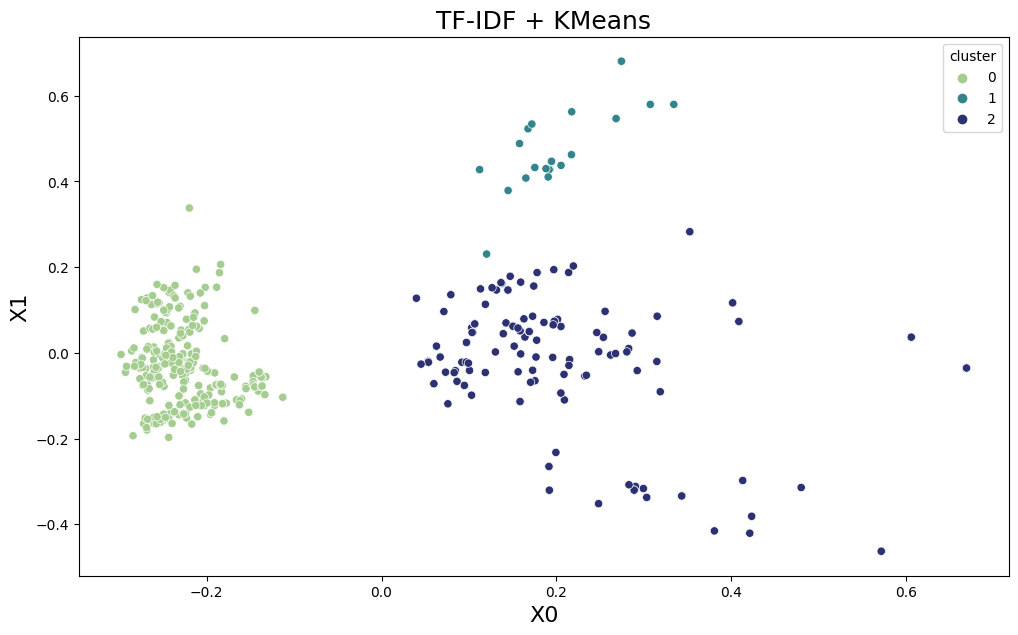

In [60]:
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="crest")
plt.show()

In [64]:
df[['scrap_type', 'corpus', 'cluster']]

,scrap_type,corpus,cluster
0,sc:ISRI_0,bare uncoated unalloyed wire nonferrous scrap ...,0
1,sc:ISRI_1,clean untinned uncoated unalloyed wire cable n...,0
2,sc:ISRI_2,unalloyed miscellaneous wire nonferrous scrap ...,0
3,sc:ISRI_3,clean unalloyed uncoated clippings punchings b...,0
4,sc:ISRI_4,unalloyed miscellaneous scrap nonferrous scrap...,0
...,...,...,...
317,sc:ANAMET_684,lead scrap e non ferrous,2
318,sc:ANAMET_685,electric motors shredded weee non ferrous,2
319,sc:ANAMET_686,black plastic scrap weee e non ferrous,2
320,sc:ANAMET_687,scrap plexiglass e non ferrous,2


In [58]:
from sklearn.model_selecnuniquemport train_test_split

X = df['description']
y = df['scrap_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=4, stratify=y)

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

print(train_vectors.shape, test_vectors.shape)

(274, 604) (184, 604)


In [59]:
print(y_train.value_counts(normalize=True))
print(" ")
print(y_test.value_counts(normalize=True))

isri      0.532847
anamet    0.467153
Name: scrap_type, dtype: float64
 
isri      0.532609
anamet    0.467391
Name: scrap_type, dtype: float64


In [60]:
model = LogisticRegression()

model.fit(train_vectors, y_train)
predicted = model.predict(test_vectors)
print(accuracy_score(y_test,predicted))

results = pd.DataFrame(columns=['true', 'pred'])
results['true'] = y_test
results['pred'] = predicted

0.9565217391304348


In [61]:
from sklearn.svm import SVC

model = SVC()

model.fit(train_vectors, y_train)
predicted = model.predict(test_vectors)
print(accuracy_score(y_test,predicted))

results = pd.DataFrame(columns=['true', 'pred'])
results['true'] = y_test
results['pred'] = predicted

0.9619565217391305


In [62]:
results

,true,pred
178,anamet,anamet
90,isri,isri
177,anamet,anamet
234,isri,isri
48,isri,isri
...,...,...
23,isri,anamet
207,anamet,isri
118,isri,isri
75,anamet,anamet
